## Multilabel Classification

Objective: How  well  can  we  classify  a  restaurant’s  cuisine  type  using  the content of their reviews as input?

### Imports

In [76]:
import numpy as np
import pandas as pd
import regex as re
import nltk

#Preprocessing
#from utils import pipeline_v2
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from textblob import TextBlob
sent_tokenizer = PunktSentenceTokenizer()

#Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm

### Functions

In [35]:
from collections import defaultdict, Counter
from tqdm import tqdm
from unidecode import unidecode
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.base import BaseEstimator

class MainPipeline(BaseEstimator):
    def __init__(self, 
                 print_output = False, 
                 no_emojis = True, 
                 no_hashtags = True,
                 hashtag_retain_words = True,
                 no_newlines = True,
                 no_urls = True,
                 no_punctuation = True,
                 no_stopwords = True,
                 custom_stopwords = [],
                 convert_diacritics = True, 
                 lowercase = True, 
                 lemmatized = True,
                 list_pos = ["n","v","a","r","s"],
                 pos_tags_list = "no_pos",
                 tokenized_output = False):
        
        self.print_output = print_output 
        self.no_emojis = no_emojis
        self.no_hashtags = no_hashtags
        self.hashtag_retain_words = hashtag_retain_words
        self.no_newlines = no_newlines
        self.no_urls = no_urls
        self.no_punctuation = no_punctuation
        self.no_stopwords = no_stopwords
        self.custom_stopwords = custom_stopwords
        self.convert_diacritics = convert_diacritics
        self.lowercase = lowercase
        self.lemmatized = lemmatized
        self.list_pos = list_pos
        self.pos_tags_list = pos_tags_list
        self.tokenized_output = tokenized_output

    def regex_cleaner(self, raw_text):

        #patterns
        newline_pattern = "(\\n)"
        hashtags_at_pattern = "([#\@@\u0040\uFF20\uFE6B])"
        hashtags_ats_and_word_pattern = "([#@]\w+)"
        emojis_pattern = "([\u2600-\u27FF])"
        url_pattern = "(?:\w+:\/{2})?(?:www)?(?:\.)?([a-z\d]+)(?:\.)([a-z\d\.]{2,})(\/[a-zA-Z\/\d]+)?" ##Note that this URL pattern is *even better*
        punctuation_pattern = "[\u0021-\u0026\u0028-\u002C\u002E-\u002F\u003A-\u003F\u005B-\u005F\u007C\u2010-\u2028\ufeff`]+"
        apostrophe_pattern = "'(?=[A-Z\s])|(?<=[a-z\.\?\!\,\s])'"
        separated_words_pattern = "(?<=\w\s)([A-Z]\s){2,}"
        ##note that this punctuation_pattern doesn't capture ' this time to allow our tokenizer to separate "don't" into ["do", "n't"]
        
        if self.no_emojis == True:
            clean_text = re.sub(emojis_pattern,"",raw_text)
        else:
            clean_text = raw_text

        if self.no_hashtags == True:
            if self.hashtag_retain_words == True:
                clean_text = re.sub(hashtags_at_pattern,"",clean_text)
            else:
                clean_text = re.sub(hashtags_ats_and_word_pattern,"",clean_text)
            
        if self.no_newlines == True:
            clean_text = re.sub(newline_pattern," ",clean_text)

        if self.no_urls == True:
            clean_text = re.sub(url_pattern,"",clean_text)
        
        if self.no_punctuation == True:
            clean_text = re.sub(punctuation_pattern,"",clean_text)
            clean_text = re.sub(apostrophe_pattern,"",clean_text)

        return clean_text

    def lemmatize_all(self, token):
    
        wordnet_lem = nltk.stem.WordNetLemmatizer()
        for arg_1 in self.list_pos[0]:
            token = wordnet_lem.lemmatize(token, arg_1)
        return token

    def main_pipeline(self, raw_text):
        
        """Preprocess strings according to the parameters"""
        if self.print_output == True:
            print("Preprocessing the following input: \n>> {}".format(raw_text))

        clean_text = self.regex_cleaner(raw_text)

        if self.print_output == True:
            print("Regex cleaner returned the following: \n>> {}".format(clean_text))

        tokenized_text = nltk.tokenize.word_tokenize(clean_text)

        tokenized_text = [re.sub("'m","am",token) for token in tokenized_text]
        tokenized_text = [re.sub("n't","not",token) for token in tokenized_text]
        tokenized_text = [re.sub("'s","is",token) for token in tokenized_text]

        if self.no_stopwords == True:
            stopwords = nltk.corpus.stopwords.words("english")
            tokenized_text = [item for item in tokenized_text if item.lower() not in stopwords]
        
        if self.convert_diacritics == True:
            tokenized_text = [unidecode(token) for token in tokenized_text]

        if self.lemmatized == True:
            tokenized_text = [self.lemmatize_all(token) for token in tokenized_text]
    
        if self.no_stopwords == True:
            tokenized_text = [item for item in tokenized_text if item.lower() not in self.custom_stopwords]

        if self.pos_tags_list == "pos_list" or self.pos_tags_list == "pos_tuples" or self.pos_tags_list == "pos_dictionary":
            pos_tuples = nltk.tag.pos_tag(tokenized_text)
            pos_tags = [pos[1] for pos in pos_tuples]
        
        if self.lowercase == True:
            tokenized_text = [item.lower() for item in tokenized_text]
        
        if self.pos_tags_list == "pos_list":
            return (tokenized_text, pos_tags)
        elif self.pos_tags_list == "pos_tuples":
            return pos_tuples   
        
        else:
            if self.tokenized_output == True:
                return tokenized_text
            else:
                detokenizer = TreebankWordDetokenizer()
                detokens = detokenizer.detokenize(tokenized_text)
                if self.print_output == True:
                    print("Pipeline returning the following result: \n>> {}".format(str(detokens)))
                return str(detokens)

In [36]:
def fold_score_calculator(y_pred, y_test, verbose=False):
    
    # Compute the binary classification scores (accuracy, precision, recall, F1, AUC) for the fold.
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred, average="weighted")
    recall = metrics.recall_score(y_test, y_pred, average="weighted")
    f1 = metrics.f1_score(y_test, y_pred, average="weighted")

    if verbose == True:
        print("Accuracy: {} \nPrecision: {} \nRecall: {} \nF1: {}".format(acc,prec,recall,f1))
    return (acc, prec, recall, f1)

### Datasets

In [45]:
reviews = pd.read_csv('C:/Users/msard/OneDrive/Desktop/Data Science/Fall 2024/Text Mining/Hyderabadi-Word-Soup/data_hyderabad/10k_reviews.csv')
restaurants = pd.read_csv('C:/Users/msard/OneDrive/Desktop/Data Science/Fall 2024/Text Mining/Hyderabadi-Word-Soup/data_hyderabad/105_restaurants.csv')

In [46]:
# Drops unnecessary columns
reviews.drop(['Reviewer', 'Metadata', 'Time', 'Pictures', 'Rating'], axis=1, inplace=True)

restaurants.drop(['Links', 'Cost', 'Collections', 'Timings'], axis=1, inplace=True)

# Merges the cuisines column with the reviews
reviews = reviews.merge(restaurants[['Name', 'Cuisines']], 
                                      left_on='Restaurant', right_on='Name', 
                                      how='left').drop(columns=['Name'])

# Cleanup
reviews.drop(['Restaurant'], axis=1, inplace=True)
reviews.dropna(subset=['Review'], inplace=True)

# Splits the Cuisines by commas
reviews['Cuisines'] = reviews['Cuisines'].apply(lambda x: [cuisine.strip() for cuisine in x.split(',')])

In [39]:
reviews.head()

,Review,Cuisines
0,"The ambience was good, food was quite good . h...","[Chinese, Continental, Kebab, European, South ..."
1,Ambience is too good for a pleasant evening. S...,"[Chinese, Continental, Kebab, European, South ..."
2,A must try.. great food great ambience. Thnx f...,"[Chinese, Continental, Kebab, European, South ..."
3,Soumen das and Arun was a great guy. Only beca...,"[Chinese, Continental, Kebab, European, South ..."
4,Food is good.we ordered Kodi drumsticks and ba...,"[Chinese, Continental, Kebab, European, South ..."


<Figure size 1000x600 with 0 Axes>

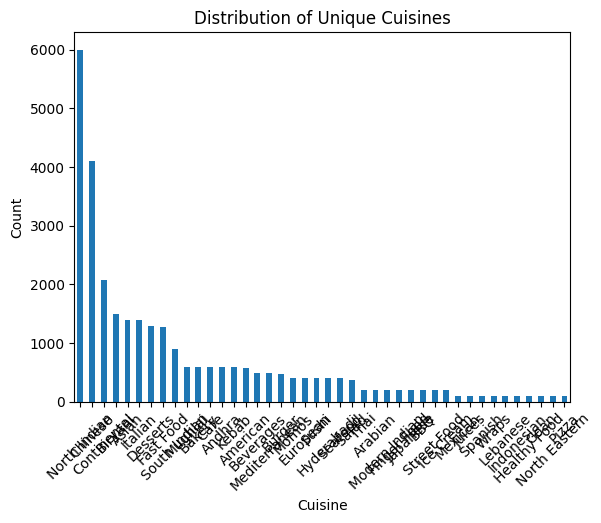

In [ ]:
'''# Flatten the list of cuisines
all_cuisines = [cuisine for sublist in reviews['Cuisines'] for cuisine in sublist]

# Count the occurrences of each unique cuisine
cuisine_counts = Counter(all_cuisines)

# Convert the counts to a DataFrame for easier plotting
cuisine_counts_df = pd.DataFrame(cuisine_counts.items(), columns=['Cuisine', 'Count'])

# Plot the distribution of unique cuisines
plt.figure(figsize=(10, 6))
cuisine_counts_df.sort_values(by='Count', ascending=False).plot(kind='bar', x='Cuisine', y='Count', legend=False)
plt.title('Distribution of Unique Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()'''

### Preprocessing

#### Basic review preprocessing

In [49]:
preprocessor = MainPipeline()

In [50]:
reviews['Preproc_Review'] =\
      reviews['Review'].map(lambda content : preprocessor.main_pipeline(content))

#### Vectorization

We use TF-IDF as a baseline and compare it to Doc2Vec.

In [51]:
#TF-IDF
vectorizer = TfidfVectorizer()
reviews_tfidf_matrix = vectorizer.fit_transform(reviews['Preproc_Review'])


reviews['tfidf_vector'] = reviews_tfidf_matrix.toarray().tolist()

In [ ]:
#Doc2Vec
# We need first to put the reviews in a tagged document object, with a (word, tag) shape
review_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews['Preproc_Review'].apply(str.split))]

doc2vec = Doc2Vec(review_docs, vector_size=100, window=2, min_count=1, workers=4)
reviews_doc2vec_matrix = [doc2vec.infer_vector(doc.split()) for doc in reviews['Preproc_Review']]

reviews['doc2vec_vector'] = reviews_doc2vec_matrix

reviews_doc2vec_matrix = np.array(reviews_doc2vec_matrix)

In [65]:
reviews_doc2vec_matrix.shape

(9955, 100)

Creating the labels matrix

In [66]:
mlb = MultiLabelBinarizer()
binarised_labels = mlb.fit_transform(reviews["Cuisines"])
reviews["cuisine_binary"] = binarised_labels.tolist()

# mlb.inverse_transform(binarised_labels)
binarised_labels.shape

(9955, 42)

### Model Testing

We use SGDClassifier because it is more efficient and scalable than Logistic Regression for high-dimensional datasets like this. Unlike Logistic regression, which loads the entire dataset into memory, SGD processes data in mini-batches using stochastic gradient descent, making it memory-efficient. It also handles sparse data, trains faster on large datasets, and supports incremental learning, which is ideal for text classification tasks with high feature counts.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(reviews_doc2vec_matrix, binarised_labels,
                                                test_size=0.2, random_state=0, stratify=binarised_labels, shuffle=True)

#### One vs Rest

In [68]:
# Define and train the SGD-based OneVsRest classifier
ovr = OneVsRestClassifier(SGDClassifier(loss="log_loss", random_state=0, class_weight="balanced"))
ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(class_weight='balanced',
                                            loss='log_loss', random_state=0))

In [69]:
# Predict
y_pred_ovr = ovr.predict(X_test)
# mlb.inverse_transform(y_pred_ovr)
fold_score_calculator(y_pred_ovr, y_test, verbose=True)

Accuracy: 0.0 
Precision: 0.3514601773396946 
Recall: 0.6485404503753127 
F1: 0.41154997180723


(0.0, 0.3514601773396946, 0.6485404503753127, 0.41154997180723)

In [33]:
print(reviews['Labels'].value_counts())

Labels
[label1, label2]    1
[label2]            1
[label1, label3]    1
[label3]            1
Name: count, dtype: int64


#### Classifier Chain

In [70]:
#Test the classifier Chain
cchain = ClassifierChain(SGDClassifier(loss="log_loss", random_state=0, class_weight="balanced"), order="random")
cchain.fit(X_train, y_train)

ClassifierChain(base_estimator=SGDClassifier(class_weight='balanced',
                                             loss='log_loss', random_state=0),
                order='random')

In [ ]:
y_pred_cchain = cchain.predict(X_test)
# mlb.inverse_transform(y_pred_q1_cchain)
fold_score_calculator(y_pred_cc, y_test, verbose=True)

Accuracy: 0.02059266700150678 
Precision: 0.3599886408673151 
Recall: 0.1804837364470392 
F1: 0.1756522824401033


c:\Users\msard\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.02059266700150678,
 0.3599886408673151,
 0.1804837364470392,
 0.1756522824401033)

### Model Optimization

In [74]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels


class HermeticClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self, preprocessor, vectorizer, classifier, d2v_vector_size=300, d2v_window=6, **kwargs):
        self.preprocessor = preprocessor
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.d2v_vector_size = d2v_vector_size
        self.d2v_window = d2v_window

    def fit(self, X, y, **kwargs):

        X_preproc = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X]

        try:
            X_train = self.vectorizer.fit_transform(X_preproc)
        except AttributeError:
            documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]
            self.d2v_model = self.vectorizer(documents, vector_size=300, window=6, min_count=1, workers=4)
            X_train = [self.d2v_model.dv[idx].tolist() for idx in range(len(X_preproc))]

        y_train = y
            
        try:
            X_train = X_train.toarray()
        except AttributeError:
            pass
        try:
            y_train = y_train.to_numpy()
        except AttributeError:
            pass

        #X_train, y_train = check_X_y(X_train, y_train)

        self.classifier.fit(X_train, y_train)

        self.X_ = X_train
        self.y_ = y_train

        return self

    def predict(self, X_test_raw, **kwargs):

        # Check if fit has been called
        check_is_fitted(self)

        X_test = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X_test_raw]

        try:
            X_test = self.vectorizer.transform(X_test)
        except AttributeError:
            X_test = [self.d2v_model.infer_vector(word_tokenize(content)).tolist() for content in X_test]

        try:
            X_test = check_array(X_test.toarray())
        except AttributeError:
            X_test = check_array(X_test)
            
        y_pred = self.classifier.predict(X_test)

        return y_pred
    

In [75]:
X_train, X_test, y_train, y_test = train_test_split(reviews["Review"], binarised_labels,
                                                    test_size=0.2, random_state=0)


In [ ]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b") 
cch_lr = ClassifierChain(LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced"), order="random")
preprocessor = MainPipeline()

hermetic_classifier = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, cch_lr)

In [78]:
hermetic_classifier.fit(X_train,y_train)
y_pred_q2 = hermetic_classifier.predict(X_test)
y_pred_q2_translated = mlb.inverse_transform(y_pred_q2)
fold_score_calculator(y_pred_q2,y_test, verbose=True)

MemoryError: Unable to allocate 8.44 GiB for an array with shape (7964, 142251) and data type float64

In [79]:
d2v = Doc2Vec 
ml_class = ClassifierChain(LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced"), order="random")
preprocessor = MainPipeline(no_stopwords=False,lemmatized=False)

hermetic_classifier2 = HermeticClassifier(preprocessor, d2v, ml_class)

hermetic_classifier2.fit(X_train,y_train)

HermeticClassifier(classifier=ClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                random_state=0),
                                              order='random'),
                   preprocessor=MainPipeline(lemmatized=False,
                                             no_stopwords=False),
                   vectorizer=<class 'gensim.models.doc2vec.Doc2Vec'>)

In [80]:
y_pred_q22 = hermetic_classifier2.predict(X_test)
y_pred_q22_translated = mlb.inverse_transform(y_pred_q22)
fold_score_calculator(y_pred_q22,y_test,verbose=True)

Accuracy: 0.011551983927674536 
Precision: 0.17820360022069023 
Recall: 0.031027044964327195 
F1: 0.026244358093880066


c:\Users\msard\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.011551983927674536,
 0.17820360022069023,
 0.031027044964327195,
 0.026244358093880066)

### Grid Search Optimization

In [82]:
import warnings
warnings.filterwarnings('ignore')

#TF-IDF unused due to memory constraints
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
bigram_bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
doc2vec_vectorizer = Doc2Vec


class_ovr = OneVsRestClassifier(LogisticRegression())
class_cc = ClassifierChain(LogisticRegression())

preprocessor = MainPipeline()

hermetic_classifier = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, ml_class)

parameter_grid = {'preprocessor__no_stopwords':[True,False],
                  'preprocessor__lemmatized':[True,False],
                  'preprocessor__lowercase':[True,False],                  
                  'vectorizer':[doc2vec_vectorizer,bigram_tfidf_vectorizer,bigram_bow_vectorizer],
                  'classifier':[class_ovr, class_cc],
                  'classifier__base_estimator__solver':['lbfgs'],
                  'classifier__base_estimator__C':[10, 1, 0.1],
                  'classifier__base_estimator__penalty':[None, 'l2'],
                  'classifier__base_estimator__class_weight':[None,'balanced'],
                  'classifier__base_estimator__random_state':[1],
                  'classifier__base_estimator__multi_class':["ovr","multinomial"],
                  'd2v_vector_size':[300], 
                  'd2v_window':[20,5]}

import warnings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models.doc2vec import Doc2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')

# Vectorizers
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
bigram_bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
doc2vec_vectorizer = Doc2Vec

# Classifiers
class_ovr = OneVsRestClassifier(LogisticRegression())
class_cc = ClassifierChain(LogisticRegression())

# Preprocessor (assuming MainPipeline is defined elsewhere)
preprocessor = MainPipeline()

# HermeticClassifier (assuming HermeticClassifier is defined elsewhere)
hermetic_classifier = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, class_ovr)

# Parameter grid
parameter_grid = {
    'preprocessor__no_stopwords': [True, False],
    'preprocessor__lemmatized': [True, False],
    'preprocessor__lowercase': [True, False],
    'vectorizer': [doc2vec_vectorizer, bigram_tfidf_vectorizer, bigram_bow_vectorizer],
    'classifier': [class_ovr, class_cc],
    'classifier__estimator__solver': ['lbfgs'],
    'classifier__estimator__C': [10, 1, 0.1],
    'classifier__estimator__penalty': [None, 'l2'],
    'classifier__estimator__class_weight': [None, 'balanced'],
    'classifier__estimator__random_state': [1],
    'classifier__estimator__multi_class': ["ovr", "multinomial"],
    'd2v_vector_size': [300],
    'd2v_window': [20, 5]
}

# Scoring metrics
scores = ["accuracy", "precision_weighted", "recall_weighted", "f1_weighted"]

# Grid search
grid_search = GridSearchCV(hermetic_classifier, parameter_grid, scoring=scores, verbose=4, refit="f1_weighted")

# Fit the model
grid_result = grid_search.fit(reviews["Review"], binarised_labels)
scores = ["accuracy","precision_weighted","recall_weighted","f1_weighted"]

grid_search = GridSearchCV(hermetic_classifier, parameter_grid, scoring=scores, verbose=4, refit="f1_weighted")

grid_result = grid_search.fit(reviews["Review"], binarised_labels)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits
[CV 1/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=None, classifier__estimator__multi_class=ovr, classifier__estimator__penalty=None, classifier__estimator__random_state=1, classifier__estimator__solver=lbfgs, d2v_vector_size=300, d2v_window=20, preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=<class 'gensim.models.doc2vec.Doc2Vec'>; accuracy: (test=nan) f1_weighted: (test=nan) precision_weighted: (test=nan) recall_weighted: (test=nan) total time=  38.3s
[CV 2/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=None, classifier__estimator__multi_class=ovr, classifier__estimator__penalty=None, classifier__estimator__random_state=1, classifier__estimator__solver=lbfgs, d2v_vector_size=300, d2v_wi

KeyboardInterrupt: 

In [83]:
grid_result.best_params_

NameError: name 'grid_result' is not defined

In [ ]:
## Best results
for score in scores:
    print("{} = {}".format(score,round(grid_result.cv_results_['mean_test_{}'.format(score)][grid_result.best_index_],3)))

### Comparing against Dummy

In [ ]:
preprocessor = pipeline_v2.MainPipeline()
dummy_classifier = ClassifierChain(DummyClassifier())
bigram_bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
hermetic_classifier3 = HermeticClassifier(preprocessor, bigram_bow_vectorizer, dummy_classifier)

parameter_grid = {'preprocessor__no_stopwords':[True],
                  'preprocessor__lemmatized':[True],
                  'preprocessor__lowercase':[True],                  
                  'vectorizer':[bigram_bow_vectorizer],
                  'classifier':[dummy_classifier],
                  'classifier__base_estimator__strategy':["most_frequent", "prior", "stratified", "uniform", "constant"]}

grid_search2 = GridSearchCV(hermetic_classifier3, param_grid=parameter_grid, scoring=scores, verbose=4, refit="f1_weighted")

grid_result2 = grid_search2.fit(reviews["Review"], binarised_labels)

In [ ]:
## Best results
for score in scores:
    print("{} = {}".format(score,round(grid_result2.cv_results_['mean_test_{}'.format(score)][grid_result2.best_index_],3)))